# Modeling: Predicting successful Kickstarter Campaigns 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd
import os
from datetime import datetime
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
ks = pd.read_csv("/Users/JamesW/Desktop/Github Repository/dataforgood/data/ks-projects-201801.csv")

## Create New Variables 

In [35]:
ks['launched'] = pd.to_datetime(ks['launched'])
ks['deadline'] = pd.to_datetime(ks['deadline'])
ks['campaign_length']= (ks.deadline -ks.launched).astype(str).str.slice(0,2).astype(int)
ks['SeasonOfLaunch'] = pd.cut(
    (ks.launched.dt.dayofyear + 11) % 366,
    [0, 91, 183, 275, 366],
    labels=['Winter', 'Spring', 'Summer', 'Fall']
)
ks['TimeOfDayOfLaunch'] = pd.cut(
    (ks.launched.dt.hour),
    [-1 ,5, 10, 17, 24],
    labels=['Late Night','Morning', 'Afternoon', 'Evening']
)
ks['year'] = ks.launched.dt.year
ks['hourofday'] = ks.launched.dt.hour
ks["success"] = np.where(ks['state'] == 'successful', True, False)
ks['US'] = np.where(ks.country=='US', 1,0)
ks['length_chars'] = ks.name.str.len()
ks['word_count'] = ks['name'].str.split().apply(len)
ks['contains_!'] = pd.get_dummies(ks.name.str.contains('!'), drop_first=True)
ks['contains_?'] = pd.get_dummies(ks.name.str.contains(r'\?'), drop_first=True)
ks['contains_title'] = pd.get_dummies(ks.name.str.istitle(), drop_first=True)

In [5]:
ks = ks.reset_index(drop=True)

In [38]:
ks.dropna(inplace = True) # REMOVE NAS CAUSE WHY NOT 


features = ks.drop(['success'],axis=1)
features = features.drop(['pledged','currency','ID','name','category','deadline','launched','hourofday','backers',
                          'usd pledged', 'usd_pledged_real','state'],axis=1)


In [39]:
features.head(3)

,main_category,goal,country,usd_goal_real,campaign_length,SeasonOfLaunch,TimeOfDayOfLaunch,year,US,length_chars,contains_!,contains_?,contains_title,word_count
0,Publishing,1000.0,GB,1533.95,58,Summer,Afternoon,2015,0,31,0,0,0,6
1,Film & Video,30000.0,US,30000.00,59,Summer,Late Night,2017,1,45,0,0,0,8
2,Film & Video,45000.0,US,45000.00,44,Winter,Late Night,2013,1,14,0,1,0,3


## Encode Varaibles for prediction purposes 

In [40]:
label_encoder = LabelEncoder()
features["main_category"] = label_encoder.fit_transform(array(features["main_category"]))
features["country"] = label_encoder.fit_transform(array(features["country"]))
features["SeasonOfLaunch"] = label_encoder.fit_transform(array(features["SeasonOfLaunch"]))
features["TimeOfDayOfLaunch"] = label_encoder.fit_transform(array(features["TimeOfDayOfLaunch"]))
features["US"] = label_encoder.fit_transform(array(features["US"]))
features["length_chars"] = label_encoder.fit_transform(array(features["length_chars"]))
features["contains_!"] = label_encoder.fit_transform(array(features["contains_!"]))
features["contains_?"] = label_encoder.fit_transform(array(features["contains_?"]))
features["contains_title"] = label_encoder.fit_transform(array(features["contains_title"]))
features["word_count"] = label_encoder.fit_transform(array(features["word_count"]))

features.head(3)

,main_category,goal,country,usd_goal_real,campaign_length,SeasonOfLaunch,TimeOfDayOfLaunch,year,US,length_chars,contains_!,contains_?,contains_title,word_count
0,12,1000.0,9,1533.95,58,2,0,2015,0,30,0,0,0,5
1,6,30000.0,21,30000.00,59,2,2,2017,1,44,0,0,0,7
2,6,45000.0,21,45000.00,44,3,2,2013,1,13,0,1,0,2


In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


X_train,X_test,Y_train,Y_test = train_test_split(features,
                                                 ks.success, test_size=0.3, random_state = 22)

# trying to get input array of ints

In [10]:
clf = RandomForestClassifier(n_estimators = 100)

In [11]:
clf.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
Y_pred=clf.predict(X_test)

In [13]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))

Accuracy: 0.6745441426675337


In [14]:
feature_imp = pd.Series(clf.feature_importances_,index=features.columns).sort_values(ascending=False)
feature_imp

length_chars         0.212076
usd_goal_real        0.145893
goal                 0.128292
campaign_length      0.122651
main_category        0.121538
year                 0.081051
SeasonOfLaunch       0.069441
TimeOfDayOfLaunch    0.052957
contains_title       0.025456
country              0.019195
contains_!           0.012885
US                   0.005261
contains_?           0.003303
dtype: float64

No handles with labels found to put in legend.


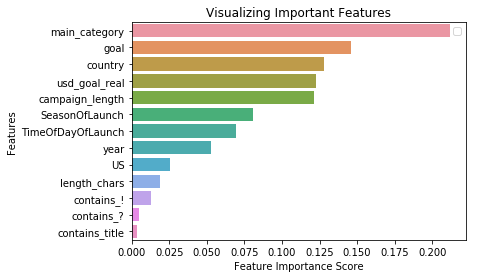

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=features.columns)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [16]:
# # CV
scores = cross_val_score(clf, features, ks.success, cv=10)

print(scores)
print()
print('Average:', np.mean(scores))
# average fold of 67% 

[0.67662542 0.67756073 0.67597541 0.67477285 0.67250134 0.67410476
 0.67159273 0.67183324 0.67693747 0.67127205]

Average: 0.6743175997163224
